## Run default configurations
Print out Psats, NET, NET_wafer


In [1]:
import glob

In [2]:
# See what yaml files are locally available.
glob.glob('*.yaml')

['CHLAT_20210714.yaml',
 'SAT_HF_20210714.yaml',
 'SAT_LF_20211015.yaml',
 'SAT_MF_20211015.yaml',
 'SPLAT_20210714.yaml']

In [ ]:
# Standard imports
import numpy as np
import yaml
import toml
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top



In [ ]:
def print_cam_tables(cam_tables):
    for keyname in cam_tables.keys():
        if 'cam' in keyname:
            print(keyname)
            dat = np.array(cam_tables[keyname])
            print('  Efficiency:         {0:3.2f}'.format(dat[0][0]))
            print('  Optical power (pW): {0:3.2f}'.format(dat[0][1]))
            print('  P_sat (pW):         {0:3.2f}'.format(dat[0][2]))
            print('  F_link:             {0:3.2f}'.format(dat[0][3]))
            print('  G:                  {0:3.2f}'.format(dat[0][4]))
            print('  NEP_bolo:           {0:3.2f}'.format(dat[0][7]))
            print('  NEP_readout:        {0:3.2f}'.format(dat[0][8]))       
            print('  NEP_photon:         {0:3.2f}'.format(dat[0][9]))
            print('  NEP_tot:            {0:3.2f}'.format(dat[0][10]))
            print('  NET_bolo:           {0:3.2f}'.format(dat[0][11]))
            print('  NET_bolo_corr:      {0:3.2f}'.format(dat[0][12]))
            print('  corr_factor:        {0:3.2f}'.format(dat[0][13]))
            print('  NET_wafer (uncorr)  {0:3.2f}'.format(dat[0][14]))
        print()

## Run
Read yaml files, run bolo_calc, store some outputs into dictionary called "data".
Print some outputs to table.

In [8]:
data = {}

yamlfiles = ['SAT_LF_20211015.yaml','SAT_MF_20211015.yaml','SAT_HF_20210714.yaml' ]
#read fixed PSATs from .toml file
psat_dict = toml.load("FixedPsats.toml")

for yamlfile in yamlfiles:
    print(yamlfile)
    data[yamlfile] = {}
    dd = yaml.safe_load(open(yamlfile))
    version_date = str(dd['version']['date'])
    version_telescope = str(dd['version']['name'])
    print('{0:8s}  Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact'.format(version_telescope))
    del dd['version']

    # location of atmosphere file
    dd['sim_config']['config_dir'] = '../scripts'
    
    ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())
    
    #---------
    #convert to Watts
    for channel in ch_names:
        psat_dict[yamlfile.partition('.')[0]][channel] *= 1e-12

    #set psat factor to None & delete psat entry from channel default
    dd['instrument']['channel_default']['psat_factor'] = None
    del dd['instrument']['channel_default']['psat']

    #assign SI psat values at the channel level
    for channel in ch_names:
        dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat_dict[yamlfile.partition('.')[0]][channel]
    #---------
    
    # Save some of the defaults things
    data[yamlfile]['defaults']={}
    data[yamlfile]['defaults']['Yield']=dd['instrument']['channel_default']['Yield']
    data[yamlfile]['defaults']['Tc']=dd['instrument']['channel_default']['Tc']
    data[yamlfile]['defaults']['waist_factor']=dd['instrument']['channel_default']['waist_factor']
    data[yamlfile]['defaults']['read_frac']=dd['instrument']['channel_default']['read_frac']
    data[yamlfile]['defaults']['site']=dd['instrument']['site']
    data[yamlfile]['defaults']['elevation']=dd['instrument']['elevation']
    data[yamlfile]['defaults']['pwv']=dd['instrument']['pwv']

    top = Top(**dd)
    top.run()
    
    for chan in top.instrument.tables.keys():
        if chan.split('_')[0] == 'cam' :
            chname = chan.split('_')[2] + '_' + chan.split('_')[3]
            data[yamlfile][chname] = {}
            #data[yamlfile][chname]['optics']={}
            #
            # Grab things we're going to print and give them short names and store them in the dictionary.
            popt = top.instrument.tables[chan]['opt_power'][0]
            data[yamlfile][chname]['popt'] = popt
            psat = top.instrument.tables[chan]['P_sat'][0]
            data[yamlfile][chname]['psat'] = psat
            net = top.instrument.tables[chan]['NET'][0]
            data[yamlfile][chname]['net'] = net
            netwafer = top.instrument.tables[chan]['NET_arr'][0]
            data[yamlfile][chname]['netwafer'] = netwafer
            #
            # Grab things we're not going to print and store them in the dictionary.
            data[yamlfile][chname]['effic'] = top.instrument.tables[chan]['effic'][0]
            data[yamlfile][chname]['nep_photon'] = top.instrument.tables[chan]['NEP_ph'][0]
            data[yamlfile][chname]['nep_phonon'] = top.instrument.tables[chan]['NEP_bolo'][0]
            data[yamlfile][chname]['nep_readout'] = top.instrument.tables[chan]['NEP_read'][0]
            data[yamlfile][chname]['Gdyn'] = top.instrument.tables[chan]['G'][0]
            corr_fact = top.instrument.tables[chan]['corr_fact'][0]
            data[yamlfile][chname]['corr_fact'] = corr_fact 
            data[yamlfile][chname]['bandcenter'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['band_center']
            data[yamlfile][chname]['fractional_bandwidth'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['fractional_bandwidth']
            dnu = 0.5*data[yamlfile][chname]['bandcenter']*data[yamlfile][chname]['fractional_bandwidth']
            data[yamlfile][chname]['band_lowedge'] = data[yamlfile][chname]['bandcenter'] - dnu
            data[yamlfile][chname]['band_highedge'] = data[yamlfile][chname]['bandcenter'] + dnu
            print('{0:5s} : {1:8.2f} {2:8.2f} {3:8.2f} {4:8.2f} {5:8.2f}'.format(chname,popt,psat,net,netwafer,corr_fact) )
    print(' ')
    

SAT_LF_20211015.yaml
SAT_LF    Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact
LF_1  :     0.62     1.55   171.24    39.08     1.04
LF_2  :     2.46     6.14   215.63    49.21     1.01
 
SAT_MF_20211015.yaml
SAT_MF    Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact
MF1_1 :     3.24     8.19   313.67    20.45     1.03
MF1_2 :     5.13    13.24   335.33    21.87     1.00
MF2_1 :     3.31     8.19   274.87    16.72     1.02
MF2_2 :     5.46    13.24   359.73    21.88     1.00
 
SAT_HF_20210714.yaml
SAT_HF    Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact
HF_1  :    13.21    33.03   726.90    26.54     1.00
HF_2  :    16.25    40.62  1747.15    63.78     1.00
 


In [9]:
top.instrument.tables.keys()

dict_keys(['cam_1_HF_1_sims', 'cam_1_HF_2_sims', 'optical'])

In [10]:
print_cam_tables(top.instrument.tables)

cam_1_HF_1_sims
  Efficiency:         0.43
  Optical power (pW): 13.21
  P_sat (pW):         33.03
  F_link:             0.52
  G:                  926.70
  NEP_bolo:           26.20
  NEP_readout:        33.23
  NEP_photon:         100.43
  NEP_tot:            108.98
  NET_bolo:           726.90
  NET_bolo_corr:      729.93
  corr_factor:        1.00
  NET_wafer (uncorr)  26.54

cam_1_HF_2_sims
  Efficiency:         0.39
  Optical power (pW): 16.25
  P_sat (pW):         40.62
  F_link:             0.52
  G:                  1139.58
  NEP_bolo:           29.06
  NEP_readout:        40.55
  NEP_photon:         123.27
  NEP_tot:            132.98
  NET_bolo:           1747.15
  NET_bolo_corr:      1750.96
  corr_factor:        1.00
  NET_wafer (uncorr)  63.78




In [11]:
for keyname in top.instrument.tables.keys():
    if 'cam' in keyname:
        print(keyname)
        dat = np.array(top.instrument.tables[keyname])
        print('  Efficiency:         {0:3.2f}'.format(dat[0][0]))
        print('  Optical power (pW): {0:3.2f}'.format(dat[0][1]))
        print('  P_sat (pW):         {0:3.2f}'.format(dat[0][2]))
        print('  F_link:             {0:3.2f}'.format(dat[0][3]))
        print('  G:                  {0:3.2f}'.format(dat[0][4]))
        print('  NEP_bolo:           {0:3.2f}'.format(dat[0][7]))
        print('  NEP_readout:        {0:3.2f}'.format(dat[0][8]))       
        print('  NEP_photon:         {0:3.2f}'.format(dat[0][9]))
        print('  NEP_tot:            {0:3.2f}'.format(dat[0][10]))
        print('  NET_bolo:           {0:3.2f}'.format(dat[0][11]))
        print('  NET_bolo_corr:      {0:3.2f}'.format(dat[0][12]))
        print('  corr_factor:        {0:3.2f}'.format(dat[0][13]))
        print('  NET_wafer (uncorr)  {0:3.2f}'.format(dat[0][14]))
    print()

cam_1_HF_1_sims
  Efficiency:         0.43
  Optical power (pW): 13.21
  P_sat (pW):         33.03
  F_link:             0.52
  G:                  926.70
  NEP_bolo:           26.20
  NEP_readout:        33.23
  NEP_photon:         100.43
  NEP_tot:            108.98
  NET_bolo:           726.90
  NET_bolo_corr:      729.93
  corr_factor:        1.00
  NET_wafer (uncorr)  26.54

cam_1_HF_2_sims
  Efficiency:         0.39
  Optical power (pW): 16.25
  P_sat (pW):         40.62
  F_link:             0.52
  G:                  1139.58
  NEP_bolo:           29.06
  NEP_readout:        40.55
  NEP_photon:         123.27
  NEP_tot:            132.98
  NET_bolo:           1747.15
  NET_bolo_corr:      1750.96
  corr_factor:        1.00
  NET_wafer (uncorr)  63.78




In [13]:
#
ncams = 2 # 4 for SAT MF, otherwise 2.

for nnn in range(ncams):
    rows = nnn*14 + np.arange(14)
    top.instrument.tables['optical']['channel', 'element','elem_effic_mean','elem_power_to_det_mean'][rows].pprint()
    print()

channel   element     elem_effic_mean   elem_power_to_det_mean
------- ------------ ------------------ ----------------------
cam_1_0          cmb                1.0    0.07200198898411314
cam_1_0         dust                1.0 5.5176143804721444e-15
cam_1_0  synchrotron                1.0   4.11826544261421e-14
cam_1_0   atmosphere 0.9464398800370454      4.330874615944832
cam_1_0       baffle 0.9899999999999914     0.9859178571851459
cam_1_0       window 0.9274315235162751      6.724004976003351
cam_1_0     RTMLI_10 0.9956499999999945    0.25102320159647484
cam_1_0 alumina_filt 0.9375897936799006     0.8245855394362664
cam_1_0   nylon_filt 0.9208980000000017   0.024851409120677126
cam_1_0        lens1 0.9720829084373913  9.398019511114074e-07
cam_1_0     aperture 0.9674875014633018  5.582622684484288e-06
cam_1_0        lens2 0.9720829084373913  1.009510021986802e-06
cam_1_0      lowpass 0.9405000000000102 1.1954367078418617e-44
cam_1_0     detector  0.670000000000006                

## Make a 4-panel plot.
Popt, Psat, NET, NET_wafer

Text(0.5, 1.0, '20210714')

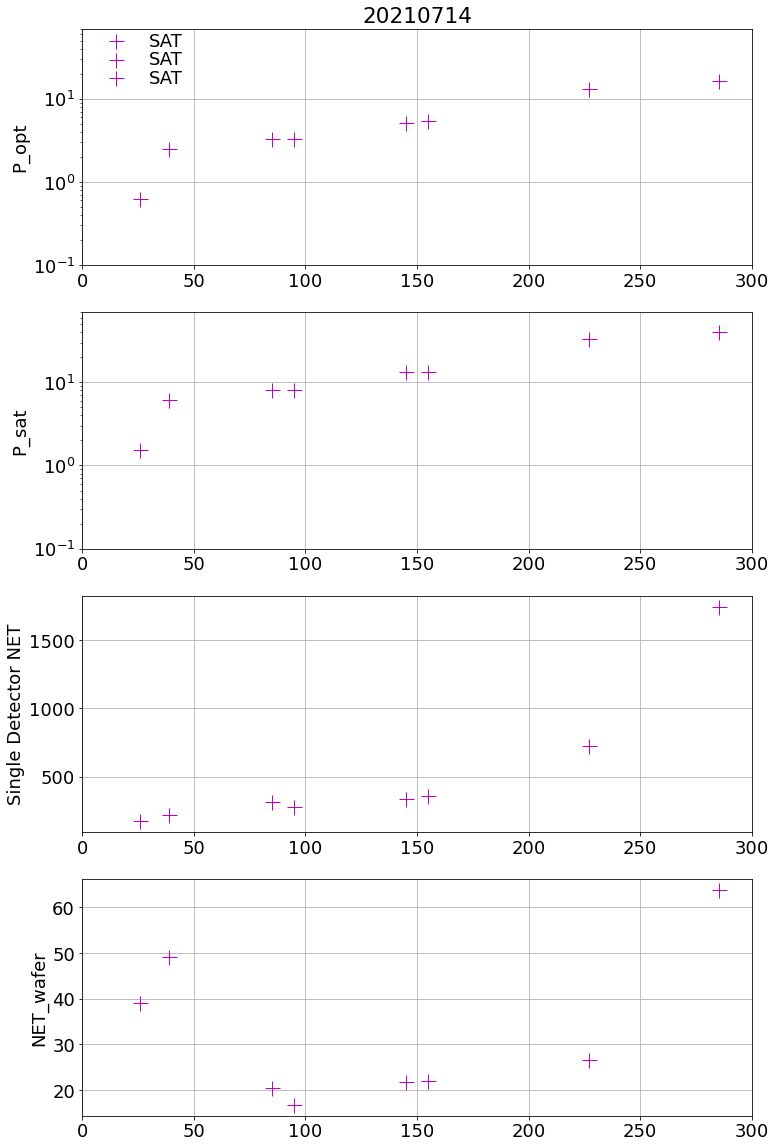

In [14]:
# Plot things vs frequency for each telescope

# Set up a 4-panel plot
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('P_opt')
ax1.set_xlim(0,300)
ax1.set_ylim(0.1,70)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('P_sat')
ax2.set_xlim(0,300)
ax2.set_ylim(0.1,70)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('Single Detector NET')
ax3.set_xlim(0,300)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NET_wafer')
ax4.set_xlim(0,300)
ax4.grid()
yfrac = 0.7

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.semilogy(nu, data[yamlfile][chname]['popt'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['psat'],pointtype, markersize=15 )
            ax3.plot(nu, data[yamlfile][chname]['net'],pointtype, markersize=15 )
            ax4.plot(nu, data[yamlfile][chname]['netwafer'],pointtype, markersize=15 )
            #
    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.05*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.semilogy(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac*0.6


ax1.grid()
ax1.grid()
ax1.set_title(version_date)
    

## Make a 4-panel plot.
efficiency, NEP_photon, NEP_phonon, NEP_readout

Text(0.5, 1.0, '20210714')

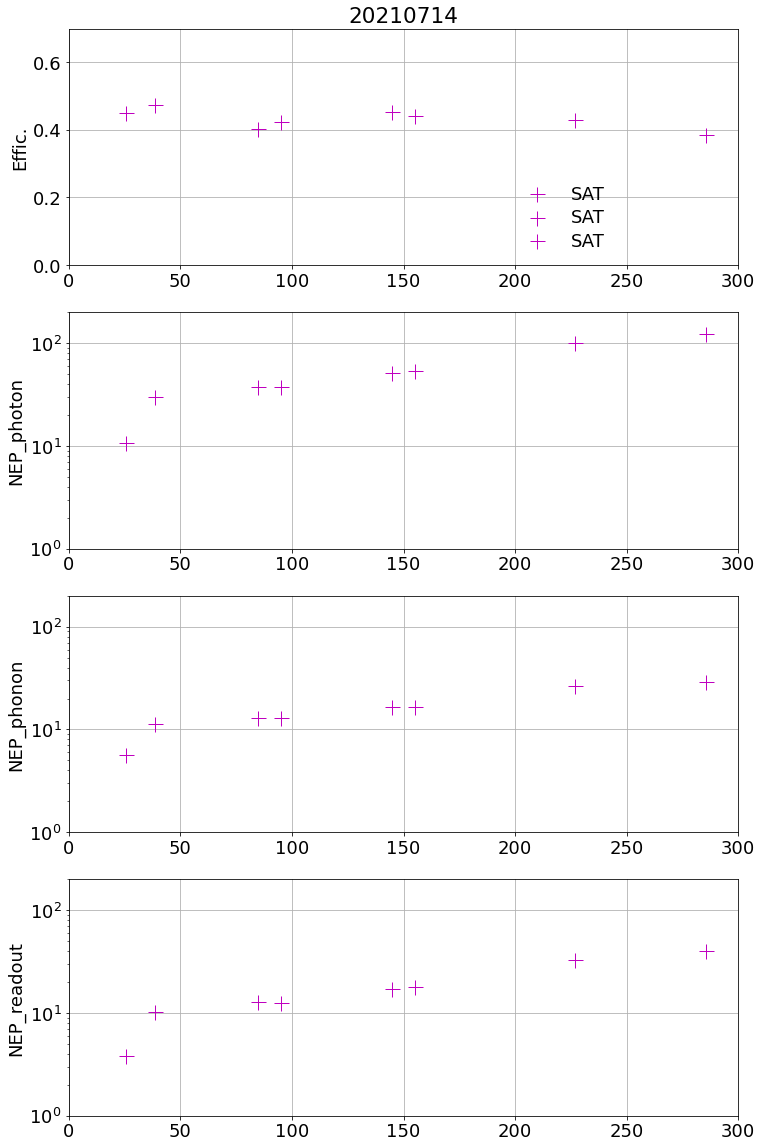

In [15]:
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('Effic.')
ax1.set_xlim(0,300)
ax1.set_ylim(0,0.7)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('NEP_photon')
ax2.set_xlim(0,300)
ax2.set_ylim(1,200)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('NEP_phonon')
ax3.set_xlim(0,300)
ax3.set_ylim(1,200)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NEP_readout')
ax4.set_xlim(0,300)
ax4.set_ylim(1,200)
ax4.grid()

#data = {}
yfrac = 0.3

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.plot(nu, data[yamlfile][chname]['effic'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['nep_photon'],pointtype, markersize=15 )
            ax3.semilogy(nu, data[yamlfile][chname]['nep_phonon'],pointtype, markersize=15 )
            ax4.semilogy(nu, data[yamlfile][chname]['nep_readout'],pointtype, markersize=15 )

    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.7*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.plot(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac-0.1


ax1.grid()
ax1.grid()
ax1.set_title(version_date)



In [16]:
# Write to files
data['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
data['input_id'] = version_date
data['variation'] = 'BaseModel'

# Write to toml file
output_file_name = data['variation'] + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(data, toml_file, encoder=toml.TomlNumpyEncoder())

## Notes
Key lists etc.

In [17]:
data2 = {}
data2['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
data2['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
data2['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

# Write to toml file
with open('FixedPsats.toml', "w") as toml_file:
    toml.dump(data2, toml_file, encoder=toml.TomlNumpyEncoder())

In [18]:
top.instrument.tables.keys()

dict_keys(['cam_1_HF_1_sims', 'cam_1_HF_2_sims', 'optical'])

In [19]:
data[yamlfile][chname]['Gdyn']

1139.5770813556937